Importing libraries and loading dataset

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import medfilt, spectrogram
from scipy.stats import mode
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

In [32]:
base_dir = 'C:/Users/Maitri/OneDrive/Desktop/maitri jain/sem3/dsa/project/wifi_csi_har_dataset'
all_data = []
all_labels = []
for room in os.listdir(base_dir):
    room_path = os.path.join(base_dir, room)
    if os.path.isdir(room_path):
        for session in os.listdir(room_path):
            session_path = os.path.join(room_path, session)
            if os.path.isdir(session_path):
                data_file = os.path.join(session_path, 'data.csv')
                label_file = os.path.join(session_path, 'label.csv')
                if os.path.exists(data_file) and os.path.exists(label_file):
                    print("Loading:", data_file)
                    data_df = pd.read_csv(data_file, header=None)
                    label_df = pd.read_csv(label_file, header=None)
                    all_data.append(data_df)
                    all_labels.append(label_df)
csi_data_full = pd.concat(all_data, axis=0, ignore_index=True)
labels_full = pd.concat(all_labels, axis=0, ignore_index=True)

print("Total samples:", csi_data_full.shape[0]) 
print("Total labels:", labels_full.shape[0])
print("CSI data shape:", csi_data_full.shape)
print("Labels shape:", labels_full.shape)

Loading: C:/Users/Maitri/OneDrive/Desktop/maitri jain/sem3/dsa/project/wifi_csi_har_dataset\room_1\1\data.csv
Loading: C:/Users/Maitri/OneDrive/Desktop/maitri jain/sem3/dsa/project/wifi_csi_har_dataset\room_1\2\data.csv
Loading: C:/Users/Maitri/OneDrive/Desktop/maitri jain/sem3/dsa/project/wifi_csi_har_dataset\room_1\3\data.csv
Loading: C:/Users/Maitri/OneDrive/Desktop/maitri jain/sem3/dsa/project/wifi_csi_har_dataset\room_1\4\data.csv
Loading: C:/Users/Maitri/OneDrive/Desktop/maitri jain/sem3/dsa/project/wifi_csi_har_dataset\room_2\1\data.csv
Loading: C:/Users/Maitri/OneDrive/Desktop/maitri jain/sem3/dsa/project/wifi_csi_har_dataset\room_3\1\data.csv
Loading: C:/Users/Maitri/OneDrive/Desktop/maitri jain/sem3/dsa/project/wifi_csi_har_dataset\room_3\2\data.csv
Loading: C:/Users/Maitri/OneDrive/Desktop/maitri jain/sem3/dsa/project/wifi_csi_har_dataset\room_3\3\data.csv
Loading: C:/Users/Maitri/OneDrive/Desktop/maitri jain/sem3/dsa/project/wifi_csi_har_dataset\room_3\4\data.csv
Loading: C

In [33]:
print("Missing CSI values:", csi_data_full.isnull().sum().sum())
print("Missing label values:", labels_full.isnull().sum().sum())
print(csi_data_full.head())

Missing CSI values: 0
Missing label values: 0
   0     1     2     3     4     5     6     7     8     9     ...      1016  \
0     0     1     2     3     4     5     6     7     8     9  ... -0.334198   
1     0     1     2     3     4     5     6     7     8     9  ... -1.766377   
2     0     1     2     3     4     5     6     7     8     9  ...  2.054746   
3     0     1     2     3     4     5     6     7     8     9  ... -0.924677   
4     0     1     2     3     4     5     6     7     8     9  ...  0.149812   

       1017      1018      1019      1020      1021      1022      1023  \
0 -0.321751 -0.387120 -0.387670 -0.452578 -0.491529 -0.530216 -0.492486   
1 -1.813444 -1.844964 -1.913092 -1.933722 -1.916352 -1.953873 -1.989021   
2  2.023271  1.964587  1.930391  1.894945  1.854590  1.807354  1.806341   
3 -0.971344 -1.006227 -1.078987 -1.068706 -1.083897 -1.107149 -1.116494   
4  0.143243  0.123086  0.113151  0.092756  0.049958  0.013698  0.075613   

       1024      1025 

Visualising the data

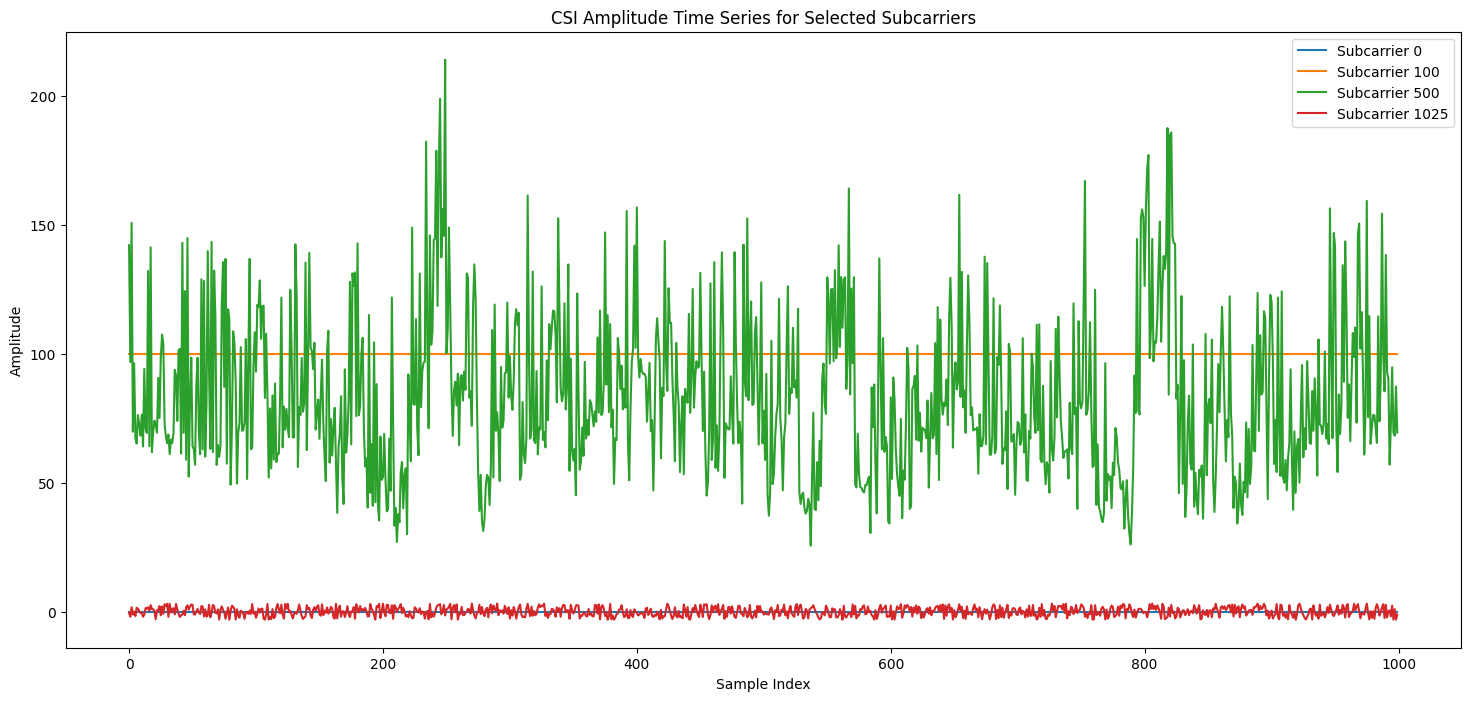

In [34]:
subcarrier_indices = [0, 100, 500, 1025]
sample_indices = np.arange(0, min(1000, csi_data_full.shape[0]))
plt.figure(figsize=(18, 8))
for idx in subcarrier_indices:
    plt.plot(sample_indices, csi_data_full.iloc[sample_indices, idx], label=f'Subcarrier {idx}')
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("CSI Amplitude Time Series for Selected Subcarriers")
plt.legend()
plt.show()

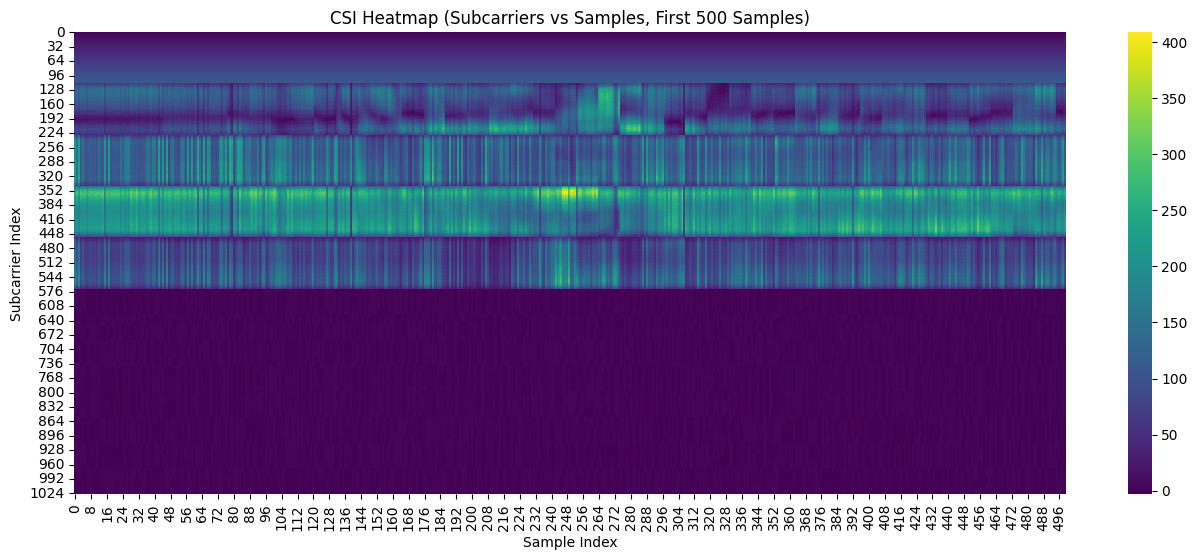

In [35]:
heatmap_data = csi_data_full.iloc[:500, :].T   
plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap='viridis', cbar=True)
plt.title("CSI Heatmap (Subcarriers vs Samples, First 500 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Subcarrier Index")
plt.show()

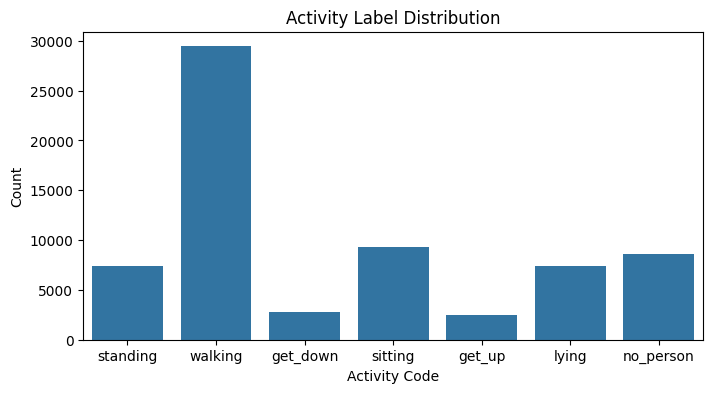

In [36]:
plt.figure(figsize=(8, 4))
sns.countplot(x=labels_full.iloc[:, 1])
plt.title("Activity Label Distribution")
plt.xlabel("Activity Code")
plt.ylabel("Count")
plt.show()

PREPROCESSING

Denoising

In [37]:
csi_arr = csi_data_full.values.astype(np.float64)
def median_denoise(data, kernel=3):
    return medfilt(data, kernel_size=(kernel,1))
csi_denoised = median_denoise(csi_arr)

Amplitude and Phase Extraction

In [38]:
csi_amplitude = np.abs(csi_denoised)
csi_phase = np.angle(csi_denoised)

Normalization

In [39]:
scaler_amp = StandardScaler()
csi_amp_norm = scaler_amp.fit_transform(csi_amplitude)

scaler_phase = StandardScaler()
csi_phase_norm = scaler_phase.fit_transform(csi_phase)

Time Alignment and Segmentation

In [40]:
window_size = 120  # Number of samples per segment
stride = 40        # Sliding window step size

def sliding_window(data, win_size, stride):
    shape = ((data.shape[0] - win_size) // stride + 1, win_size, data.shape[1])
    strides = (data.strides[0]*stride, data.strides[0], data.strides[1])
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

amp_windows = sliding_window(csi_amp_norm, window_size, stride)
phase_windows = sliding_window(csi_phase_norm, window_size, stride)

print(f"Amplitude windows shape: {amp_windows.shape}")  

Amplitude windows shape: (1684, 120, 1026)


Feature Extraction

In [41]:
def window_spectrogram(window):
    f, t, Sxx = spectrogram(window, axis=0)
    return Sxx.flatten()

spec_features_list = []
for i in range(min(100, amp_windows.shape[0])):
    spec_feat = window_spectrogram(amp_windows[i])
    spec_features_list.append(spec_feat)

spec_features = np.array(spec_features_list)

pca = PCA(n_components=40)
spec_features_pca = pca.fit_transform(spec_features)

print(f"Spectrogram PCA feature matrix shape: {spec_features_pca.shape}")

C:\Users\Maitri\AppData\Local\Temp\ipykernel_21800\483643800.py:2: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  f, t, Sxx = spectrogram(window, axis=0)


Spectrogram PCA feature matrix shape: (100, 40)


Correlation of Features after PCA

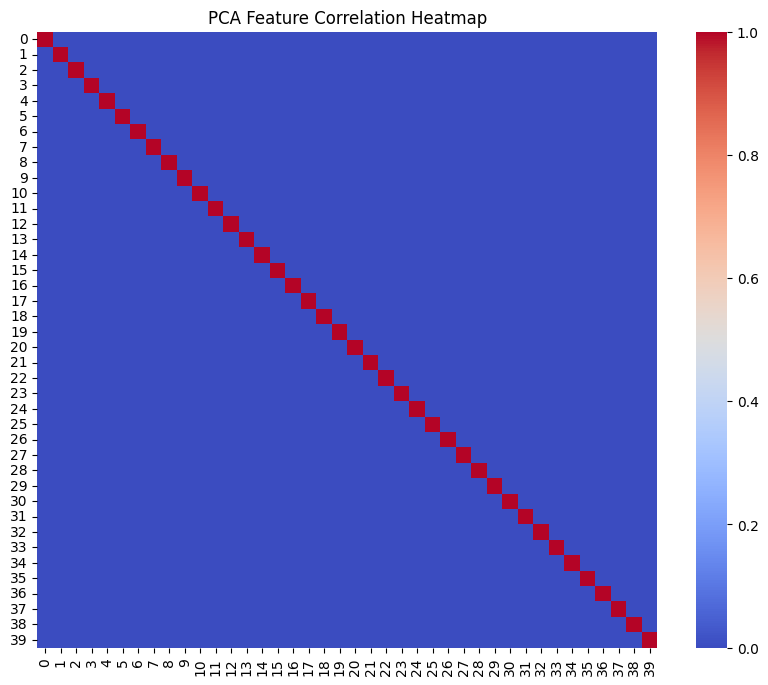

In [42]:
corr = pd.DataFrame(spec_features_pca).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('PCA Feature Correlation Heatmap')
plt.show()


Label Alignment

In [43]:
activity_labels = labels_full.iloc[:, 1].values
num_windows = (len(activity_labels) - window_size) // stride + 1
window_labels = []

for i in range(num_windows):
    start = i * stride
    end = start + window_size
    window_segment = activity_labels[start:end]
    if len(window_segment) == 0:
        window_labels.append(None)
    else:
        most_common_label = Counter(window_segment).most_common(1)[0][0]
        window_labels.append(most_common_label)
window_labels = np.array(window_labels)
print(f"Window labels shape: {window_labels.shape}")  
print(f"Unique labels assigned: {np.unique(window_labels)}")

Window labels shape: (1683,)
Unique labels assigned: ['get_down' 'get_up' 'lying' 'no_person' 'sitting' 'standing' 'walking']


Outliers and their removal

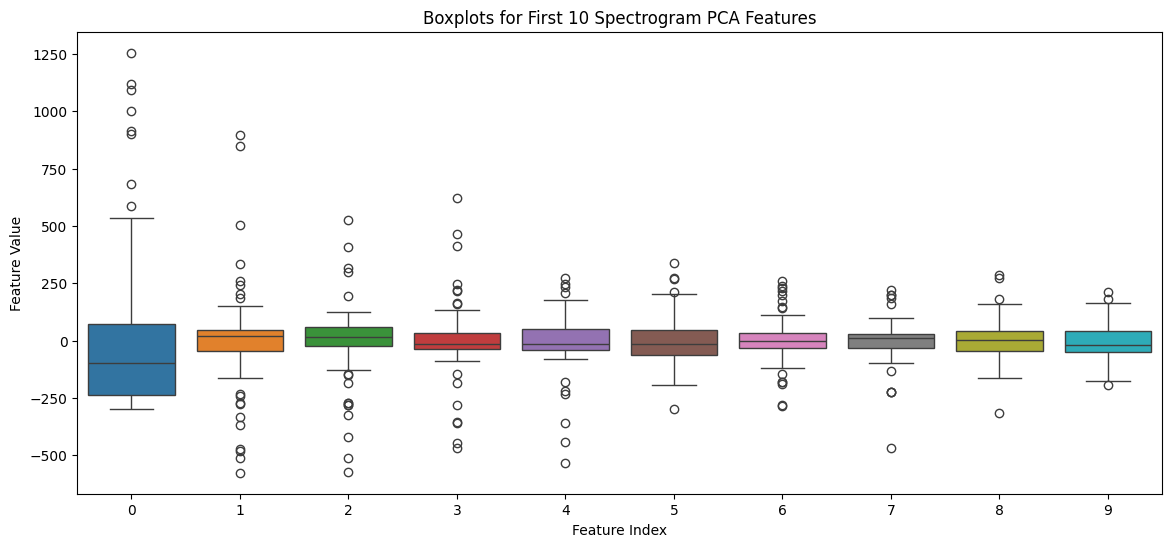

In [44]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=spec_features_pca[:,:10]) 
plt.title("Boxplots for First 10 Spectrogram PCA Features")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.show()

In [45]:
z_scores = np.abs(zscore(spec_features_pca, axis=0))
threshold =3.5
outlier_mask = np.any(z_scores > threshold, axis=1)  
print(f"Detected {np.sum(outlier_mask)} outlier windows from total {spec_features_pca.shape[0]}")
subset_labels = window_labels[:spec_features_pca.shape[0]]
                              
features_clean = spec_features_pca[~outlier_mask]
labels_clean = subset_labels[~outlier_mask]

print("Clean feature matrix shape:", features_clean.shape)
print("Cleaned label array shape:", labels_clean.shape)

Detected 10 outlier windows from total 100
Clean feature matrix shape: (90, 40)
Cleaned label array shape: (90,)


Minor Class Oversampling

In [46]:

def simple_oversample(X, y):
    counter = Counter(y)
    max_samples = max(counter.values())
    target = max(int(max_samples // 2), 12)
    X_new, y_new = [], []
    for label in np.unique(y):
        idx = np.where(y == label)[0]
        reps = int(np.ceil(target / len(idx)))
        X_new.extend(list(X[idx]) * reps)
        y_new.extend(list(y[idx]) * reps)
    X_os = np.array(X_new)
    y_os = np.array(y_new)
    p = np.random.permutation(len(y_os))
    return X_os[p], y_os[p]

features_os, labels_os = simple_oversample(features_clean, labels_clean)

Label Encoding

In [47]:
unique, counts = np.unique(labels_os, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class '{label}': {count} samples")

Class 'get_down': 20 samples
Class 'get_up': 20 samples
Class 'lying': 30 samples
Class 'no_person': 26 samples
Class 'sitting': 20 samples
Class 'standing': 24 samples
Class 'walking': 41 samples


In [48]:
label_map = {
    'get_down': 'transition',
    'get_up': 'transition',
    'lying': 'resting',
    'no_person': 'no_person',
    'sitting': 'resting',
    'standing': 'standing',
    'walking': 'walking'
}

labels_merged = [label_map[label] for label in labels_os]


In [49]:
df_combined = pd.DataFrame(features_os)
df_combined['label'] = labels_merged    
df_combined.to_csv("combined_dataset.csv", index=False)

In [50]:
unique, counts = np.unique(labels_merged, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class '{label}': {count} samples")

Class 'no_person': 26 samples
Class 'resting': 50 samples
Class 'standing': 24 samples
Class 'transition': 40 samples
Class 'walking': 41 samples


In [51]:
classes = np.unique(labels_merged)  
class_to_idx = {label: idx for idx, label in enumerate(classes)}
labels_encoded = np.array([class_to_idx[label] for label in labels_merged])

Data splitting

In [52]:
X_train, X_temp, y_train, y_temp = train_test_split(features_os,labels_encoded, test_size=0.3, stratify=labels_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (126, 40)
Validation shape: (27, 40)
Test shape: (28, 40)


Dataset Class

In [53]:
class HARCSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]

batch_size = 8
train_ds = HARCSIDataset(X_train, y_train)
val_ds = HARCSIDataset(X_val, y_val)
test_ds = HARCSIDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

CNN + LSTM Hybrid Model

In [54]:
class CNN_LSTM_HAR(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN_LSTM_HAR, self).__init__()
        # CNN Layer: 1D convolution over feature axis
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        # LSTM input features = CNN output features
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)  
        x = x.permute(0, 2, 1)  
        output, _ = self.lstm(x)
        output = output[:, -1, :]  
        output = self.fc(output)
        return output

model = CNN_LSTM_HAR(input_size=features_os.shape[1], num_classes=len(np.unique(labels_encoded)))
print(model)


CNN_LSTM_HAR(
  (cnn): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
  )
  (lstm): LSTM(64, 64, batch_first=True)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=5, bias=True)
  )
)


Training Setup

In [55]:
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

def train_epoch(model, loader):
    model.train()
    running_loss, correct = 0.0, 0
    for X, y in loader:
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
        preds = torch.argmax(out, dim=1)
        correct += (preds == y).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

def eval_epoch(model, loader):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for X, y in loader:
            out = model(X)
            loss = loss_fn(out, y)
            running_loss += loss.item() * X.size(0)
            preds = torch.argmax(out, dim=1)
            correct += (preds == y).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

best_val_acc, patience, wait = 0.0, 15,0
for epoch in range(100):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = eval_epoch(model, val_loader)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        wait = 0
    else:
        wait += 1
        if wait > patience:
            print("Early stopping triggered!")
            break

Epoch 1: Train Acc=0.167, Val Acc=0.370
Epoch 2: Train Acc=0.421, Val Acc=0.444
Epoch 3: Train Acc=0.452, Val Acc=0.407
Epoch 4: Train Acc=0.437, Val Acc=0.407
Epoch 5: Train Acc=0.548, Val Acc=0.519
Epoch 6: Train Acc=0.587, Val Acc=0.481
Epoch 7: Train Acc=0.627, Val Acc=0.667
Epoch 8: Train Acc=0.683, Val Acc=0.519
Epoch 9: Train Acc=0.746, Val Acc=0.704
Epoch 10: Train Acc=0.810, Val Acc=0.667
Epoch 11: Train Acc=0.833, Val Acc=0.667
Epoch 12: Train Acc=0.825, Val Acc=0.704
Epoch 13: Train Acc=0.889, Val Acc=0.704
Epoch 14: Train Acc=0.889, Val Acc=0.778
Epoch 15: Train Acc=0.929, Val Acc=0.741
Epoch 16: Train Acc=0.968, Val Acc=0.741
Epoch 17: Train Acc=0.976, Val Acc=0.778
Epoch 18: Train Acc=0.992, Val Acc=0.778
Epoch 19: Train Acc=0.976, Val Acc=0.778
Epoch 20: Train Acc=0.968, Val Acc=0.815
Epoch 21: Train Acc=0.976, Val Acc=0.778
Epoch 22: Train Acc=0.976, Val Acc=0.778
Epoch 23: Train Acc=0.992, Val Acc=0.741
Epoch 24: Train Acc=1.000, Val Acc=0.778
Epoch 25: Train Acc=0.992

In [56]:
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = eval_epoch(model, test_loader)
print(f"Test accuracy: {test_acc:.3f}")

# For confusion matrix and classification report:
all_preds, all_true = [], []
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        out = model(X)
        preds = torch.argmax(out, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(y.cpu().numpy())
print(confusion_matrix(all_true, all_preds))
print(classification_report(all_true, all_preds))

Test accuracy: 0.750
[[3 0 0 0 1]
 [0 7 0 0 1]
 [0 0 3 0 0]
 [3 0 0 3 0]
 [1 1 0 0 5]]
              precision    recall  f1-score   support

           0       0.43      0.75      0.55         4
           1       0.88      0.88      0.88         8
           2       1.00      1.00      1.00         3
           3       1.00      0.50      0.67         6
           4       0.71      0.71      0.71         7

    accuracy                           0.75        28
   macro avg       0.80      0.77      0.76        28
weighted avg       0.81      0.75      0.76        28



In [57]:
torch.save(model.state_dict(), "trained_model.pth")